# <div style="color:white;display:inline-block;border-radius:5px;background-color:#e6179c ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #ddc0f6;"><b> </b>📚🔗 Import Libraries</p></div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error, confusion_matrix, accuracy_score, classification_report
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from scipy.stats import kde
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, Title
from bokeh.palettes import Category20c
from bokeh.transform import cumsum
from math import pi

import warnings
warnings.filterwarnings('ignore')


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#e6179c ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #ddc0f6;"><b> </b>📂🔍 Data Loading and Exploration:</p></div>


- It prints the shape (number of rows and columns) of the training, testing, and submission files to understand the amount of data.
- It displays the first few rows of the training and testing data to get a quick look at the columns and their values.
- It calculates and shows descriptive statistics (like mean, standard deviation, min, max) for the numerical columns in the training data to get a sense of the data distribution.
- It prints a summary of the data types of each column and checks for any missing values (null values) in the training data.

In [5]:
# Load datasets
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)
print("Sample submission shape:", sample_submission.shape)

Train data shape: (750000, 10)
Test data shape: (250000, 9)
Sample submission shape: (250000, 2)


In [6]:
train_df.head().style.background_gradient(cmap='gist_rainbow_r')

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [7]:
test_df.head().style.background_gradient(cmap='gist_rainbow_r')

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


In [8]:
sample_submission.head().style.background_gradient(cmap= 'Spectral_r')

,id,Fertilizer Name
0,750000,14-35-14 10-26-26 Urea
1,750001,14-35-14 10-26-26 Urea
2,750002,14-35-14 10-26-26 Urea
3,750003,14-35-14 10-26-26 Urea
4,750004,14-35-14 10-26-26 Urea


In [9]:
train_df.describe().style.background_gradient(cmap='YlOrBr_r')

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [10]:
test_df.describe().style.background_gradient(cmap='Purples_r')

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,31.491648,61.045120,45.190444,23.139612,9.487764,21.122060
std,72168.927986,4.024093,6.636372,11.793167,11.215956,5.766860,12.380870
min,750000.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,812499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,874999.500000,31.000000,61.000000,45.000000,23.000000,10.000000,21.000000
75%,937499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,999999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


In [12]:
train_df.isnull().sum()

,0
id,0
Temparature,0
Humidity,0
Moisture,0
Soil Type,0
Crop Type,0
Nitrogen,0
Potassium,0
Phosphorous,0
Fertilizer Name,0


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#e6179c ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #ddc0f6;"><b> </b>Helper Functions:</p></div>

- The code defines a few functions to make the data visualization and reporting easier:
  - **set_plot_style**: Applies a consistent style (title, labels, grid) to the plots.
  - **print_styled**: Prints text to the console with a specified color and bolding for better readability.

In [13]:
# Helper function for consistent plot styling
def set_plot_style(ax, title, xlabel, ylabel, title_fontsize=16, label_fontsize=14, grid=True):
    ax.set_title(title, fontsize=title_fontsize, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=label_fontsize, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=label_fontsize, fontweight='bold')
    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor('#f0f0f0')  # Set a light background color

# Helper function to print results with styling
def print_styled(text, color='blue', bold=True):
    style = f"color: {color};"
    if bold:
        style += "font-weight: bold;"
    print(f"\n\033[{style}m{text}\033[0m") # ANSI escape codes for styling


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#e6179c ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #ddc0f6;"><b> </b>📊🔍🧪 Exploratory Data Analysis (EDA) and Visualization:</p></div>

- **Density Plot of Nitrogen**: Creates a smooth curve showing the distribution of nitrogen levels in the training data.
- **Pie Chart of Fertilizer Distribution**: Shows the proportion of each type of fertilizer used in the training data as slices of a pie.
- **Stacked Area Chart of Soil-Crop Combinations**: Displays the count of each crop type within each soil type. The areas are stacked to show the total count for each soil type.
- **Scatter Plot of Nitrogen vs. Phosphorous**: Shows the relationship between nitrogen and phosphorous levels, with each point colored according to the fertilizer used.
- **Heatmap of Correlation Matrix**: Displays the correlation coefficients between numerical features (Nitrogen, Phosphorous, etc.) as a color-coded matrix. This helps identify features that are strongly related.
- **Stacked Bar Chart**: Shows the distribution of crop types within each soil type using stacked bars.

Nitrogen Summary Stats:
 count    750000.000000
mean         23.093808
std          11.216125
min           4.000000
25%          13.000000
50%          23.000000
75%          33.000000
max          42.000000
Name: Nitrogen, dtype: float64


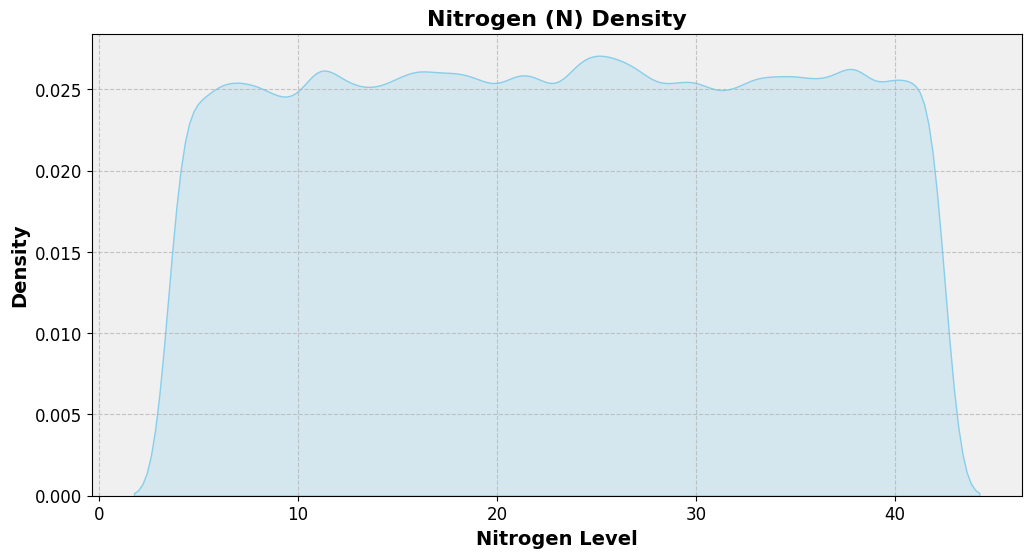

In [14]:
# 1. Density Plot
plt.figure(figsize=(12, 6))
print("Nitrogen Summary Stats:\n", train_df['Nitrogen'].describe())  # Print result
sns.kdeplot(train_df['Nitrogen'], shade=True, color='skyblue')
set_plot_style(plt.gca(), 'Nitrogen (N) Density', 'Nitrogen Level', 'Density')
plt.show()

Fertilizer Counts:
 Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64


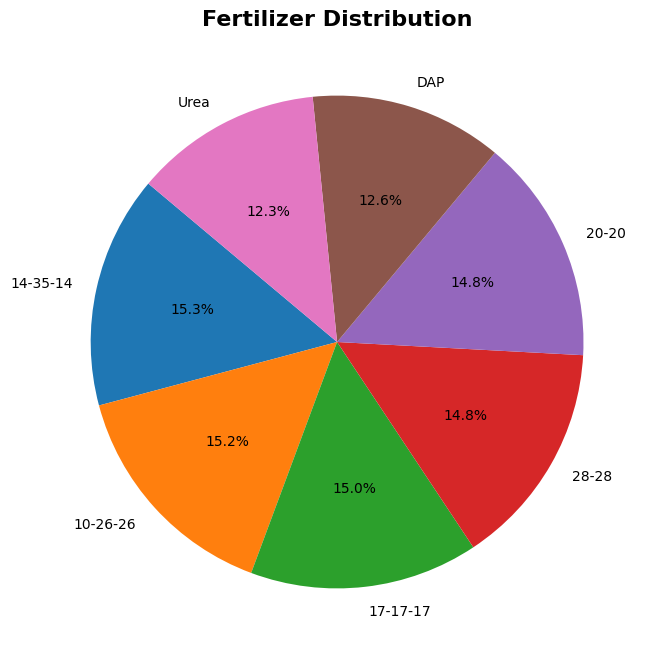

In [15]:
# 2. Burtin-Pie Chart
fertilizer_counts = train_df['Fertilizer Name'].value_counts()
print("Fertilizer Counts:\n", fertilizer_counts)  # Print result
plt.figure(figsize=(8, 8))
plt.pie(fertilizer_counts, labels=fertilizer_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Fertilizer Distribution', fontsize=16, fontweight='bold')
plt.show()

Soil-Crop Group Counts:
 Crop Type  Barley  Cotton  Ground Nuts  Maize  Millets  Oil seeds  Paddy  \
Soil Type                                                                  
Black       13266   13022        12535  12761    13265      11923  18410   
Clayey      12370   14242        11650  12599    12896      12525  16244   
Loamy       13259   13148        11840  11706    12413      12981  16869   
Red         12269   13941        11939  12211    13342      13190  16679   
Sandy       13881   14818        12945  13292    13375      13565  17552   

Crop Type  Pulses  Sugarcane  Tobacco  Wheat  
Soil Type                                     
Black       15316      13766    13327  13365  
Clayey      16122      12739    13716  13279  
Loamy       14759      12286    13611  12978  
Red         15577      12166    13441  13347  
Sandy       16406      13312    13905  13659  


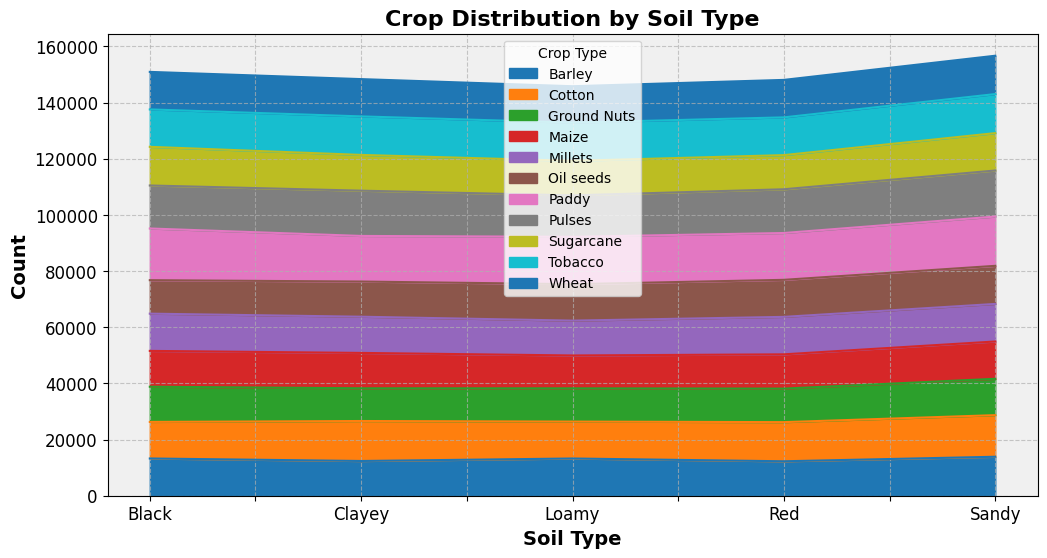

In [16]:
# 3. Stacked Area Chart
soil_crop = train_df.groupby(['Soil Type', 'Crop Type']).size().unstack()
print("Soil-Crop Group Counts:\n", soil_crop.fillna(0).astype(int))  # Print result
soil_crop.plot(kind='area', figsize=(12, 6))
set_plot_style(plt.gca(), 'Crop Distribution by Soil Type', 'Soil Type', 'Count')
plt.show()


Sample of N vs P vs Fertilizer:
    Nitrogen  Phosphorous Fertilizer Name
0        36            5           28-28
1        30           18           28-28
2        24           16        17-17-17
3        39            4        10-26-26
4        37           16             DAP


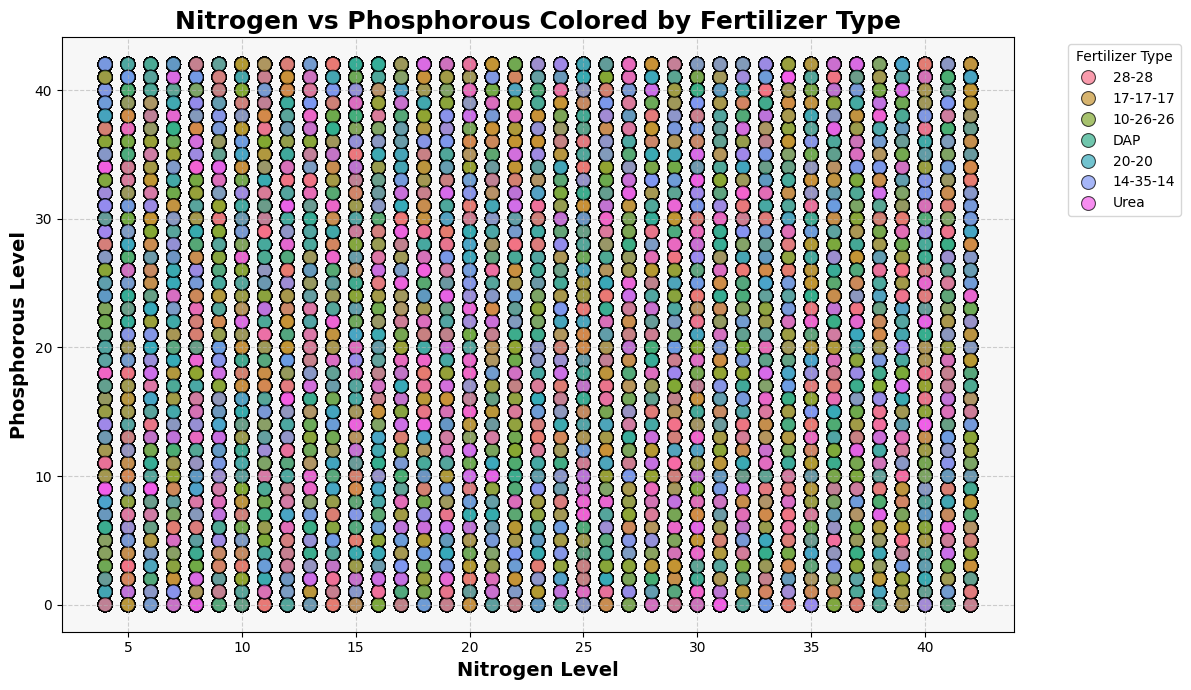

In [17]:
# 4. Enhanced Scatter Plot (N vs P colored by Fertilizer)
print("Sample of N vs P vs Fertilizer:\n", train_df[['Nitrogen', 'Phosphorous', 'Fertilizer Name']].head())  # Print result
plt.figure(figsize=(12, 7))
palette = sns.color_palette("husl", n_colors=train_df['Fertilizer Name'].nunique())
sns.scatterplot(
    x='Nitrogen',
    y='Phosphorous',
    hue='Fertilizer Name',
    palette=palette,
    data=train_df,
    s=100,
    edgecolor='black',
    alpha=0.7
)
plt.title('Nitrogen vs Phosphorous Colored by Fertilizer Type', fontsize=18, fontweight='bold')
plt.xlabel('Nitrogen Level', fontsize=14, fontweight='bold')
plt.ylabel('Phosphorous Level', fontsize=14, fontweight='bold')
plt.legend(title='Fertilizer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_facecolor('#f7f7f7')
plt.tight_layout()
plt.show()

Correlation Matrix:
              Nitrogen  Phosphorous  Potassium  Temparature  Humidity  Moisture
Nitrogen     1.000000    -0.005464   0.000543    -0.006073  0.006502  0.003016
Phosphorous -0.005464     1.000000   0.000113     0.000298  0.002413 -0.006735
Potassium    0.000543     0.000113   1.000000    -0.009913  0.005229 -0.001931
Temparature -0.006073     0.000298  -0.009913     1.000000  0.001758 -0.001633
Humidity     0.006502     0.002413   0.005229     0.001758  1.000000  0.003424
Moisture     0.003016    -0.006735  -0.001931    -0.001633  0.003424  1.000000


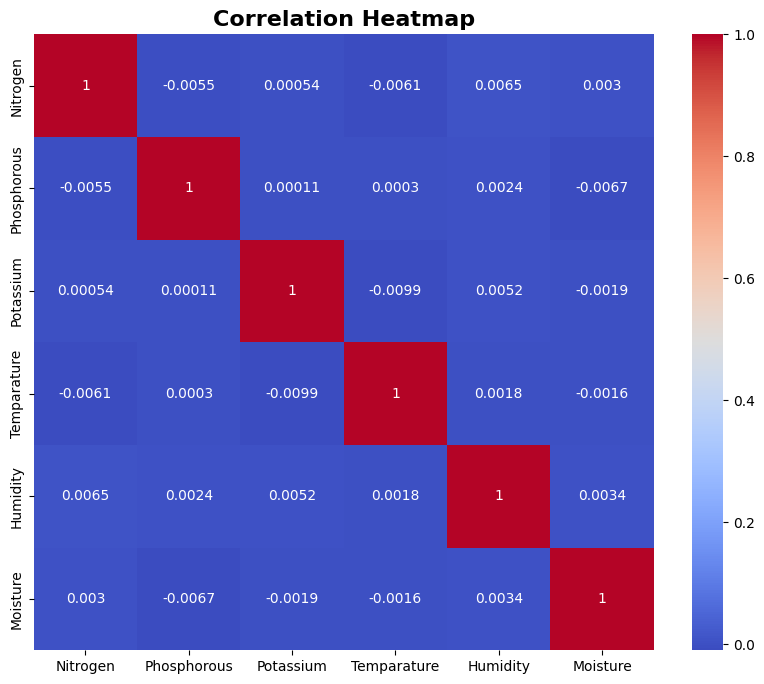

In [18]:
# 5. Heatmap (Correlation Matrix)
correlation_matrix = train_df[['Nitrogen', 'Phosphorous', 'Potassium', 'Temparature', 'Humidity', 'Moisture']].corr()
print("Correlation Matrix:\n", correlation_matrix)  # Print result
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.show()

Stacked Bar Data:
 Crop Type  Barley  Cotton  Ground Nuts  Maize  Millets  Oil seeds  Paddy  \
Soil Type                                                                  
Black       13266   13022        12535  12761    13265      11923  18410   
Clayey      12370   14242        11650  12599    12896      12525  16244   
Loamy       13259   13148        11840  11706    12413      12981  16869   
Red         12269   13941        11939  12211    13342      13190  16679   
Sandy       13881   14818        12945  13292    13375      13565  17552   

Crop Type  Pulses  Sugarcane  Tobacco  Wheat  
Soil Type                                     
Black       15316      13766    13327  13365  
Clayey      16122      12739    13716  13279  
Loamy       14759      12286    13611  12978  
Red         15577      12166    13441  13347  
Sandy       16406      13312    13905  13659  


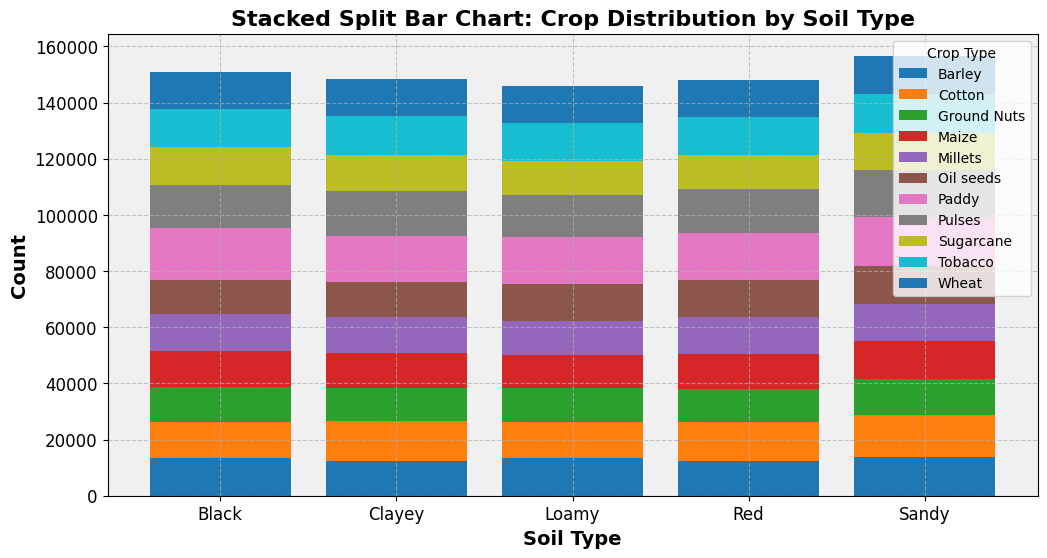

In [19]:
# 6. Stacked Split Bar Chart
soil_crop = train_df.groupby(['Soil Type', 'Crop Type']).size().unstack()
print("Stacked Bar Data:\n", soil_crop.fillna(0).astype(int))  # Print result

# Plotting using matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(soil_crop))
for crop in soil_crop.columns:
    ax.bar(soil_crop.index, soil_crop[crop], bottom=bottom, label=crop)
    bottom += soil_crop[crop]

set_plot_style(ax, 'Stacked Split Bar Chart: Crop Distribution by Soil Type', 'Soil Type', 'Count')
ax.legend(title='Crop Type')
plt.show()


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#e6179c ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #ddc0f6;"><b> </b>🛠️🧼 Feature Engineering and Preprocessing:</p></div>

- **Label Encoding**: Converts categorical features like **"Crop Type" and "Soil Type"** into numerical values. Machine learning models generally work better with numbers.
- **Create 'Season' Feature**: Creates a new feature called "Season" based on the temperature and humidity levels. It categorizes the season as **'Summer', 'Winter', 'Spring', 'Rainy', or 'Unknown'**.
- **One-Hot Encoding 'Season'**: Converts the **"Season"** feature into multiple binary (0 or 1) columns, one for each season. This is done because the model can't directly understand the categories **'Summer', 'Winter'**, etc.
- **Align Columns**: Ensures that the training and testing datasets have the same columns after the one-hot encoding step. If one dataset has a column that the other doesn't, it adds the missing column and fills it with 0s. This is important because the model needs the same features during training and prediction.
- **Sort Columns**: Sorts the columns in both training and testing datasets alphabetically to ensure they're in the same order.

In [20]:
# Feature Engineering and Preprocessing
# Label Encoding
label_encoder = LabelEncoder()
train_df['Crop Type'] = label_encoder.fit_transform(train_df['Crop Type'])
test_df['Crop Type'] = label_encoder.transform(test_df['Crop Type'])
train_df['Soil Type'] = label_encoder.fit_transform(train_df['Soil Type'])
test_df['Soil Type'] = label_encoder.transform(test_df['Soil Type'])

# Create a 'Season' column
def create_season(df):
    df['Season'] = 'Unknown'
    df.loc[(df['Temparature'] > 30) & (df['Humidity'] > 60), 'Season'] = 'Summer'
    df.loc[(df['Temparature'] < 20) & (df['Humidity'] > 70), 'Season'] = 'Winter'
    df.loc[(df['Temparature'] >= 20) & (df['Temparature'] <= 30) & (df['Humidity'] >= 40) & (df['Humidity'] <= 70), 'Season'] = 'Spring'
    df.loc[(df['Temparature'] >= 20) & (df['Temparature'] <= 30) & (df['Humidity'] >= 70), 'Season'] = 'Rainy'
    return df

train_df = create_season(train_df)
test_df = create_season(test_df)

# One-Hot Encoding for 'Season'
train_df = pd.get_dummies(train_df, columns=['Season'], drop_first=True, dummy_na=False)
test_df = pd.get_dummies(test_df, columns=['Season'], drop_first=True, dummy_na=False)

# Align columns after one-hot encoding
train_cols = set(train_df.columns)
test_cols = set(test_df.columns)
missing_in_test = list(train_cols - test_cols)
missing_in_train = list(test_cols - train_cols)

for col in missing_in_test:
    if col not in ['Fertilizer Name']:  # Exclude target column
        test_df[col] = 0
for col in missing_in_train:
    train_df[col] = 0

# Ensure same order
train_df = train_df.sort_index(axis=1)
test_df = test_df.sort_index(axis=1)

# <div style="color:white;display:inline-block;border-radius:5px;background-color:#e6179c ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #ddc0f6;"><b> </b>🧠🏋️‍♂️🔁 Model Training and Cross-Validation (XGBoost):</p></div>

This section builds and evaluates the XGBoost model:

- **Define Features and Target**: Specifies which columns are the features (input variables) and which column is the target (the variable we want to predict, i.e., **"Fertilizer Name"**).
- **Label Encode Target**: Converts the target variable (**"Fertilizer Name"**) into numerical labels.
- **XGBoost Parameters**: Sets the parameters for the XGBoost model, such as the learning rate, maximum depth of trees, and subsample ratio.
- **Cross-Validation Setup**: Configures a stratified k-fold cross-validation strategy. This splits the training data into k (in this case, 5) different **"folds."** The model is trained on `k-1` folds and evaluated on the remaining fold. This is repeated k times, with a different fold used for evaluation each time. This helps get a more robust estimate of the model's performance.
- **Cross-Validation Loop**: Iterates through each fold in the cross-validation:
  - **Split Data**: Splits the training data into training and validation sets for the current fold.
  - **Create DMatrix**: Converts the training and validation data into the DMatrix format, which is a data structure optimized for XGBoost.
  - **Train Model**: Trains the XGBoost model on the training data and evaluates its performance on the validation data. Early stopping is used to prevent overfitting.
  - **Make Predictions**: Makes predictions on the validation data and the test data.
  - **Store Feature Importances**: Records the importance of each feature in the model.
- **Calculate Overall Log Loss**: Calculates the overall log loss across all folds to evaluate the model's performance.
- **Feature Importance Analysis**: Calculates the average feature importance across all folds and plots the most important features.

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Overall Log Loss: 1.9143304688140041


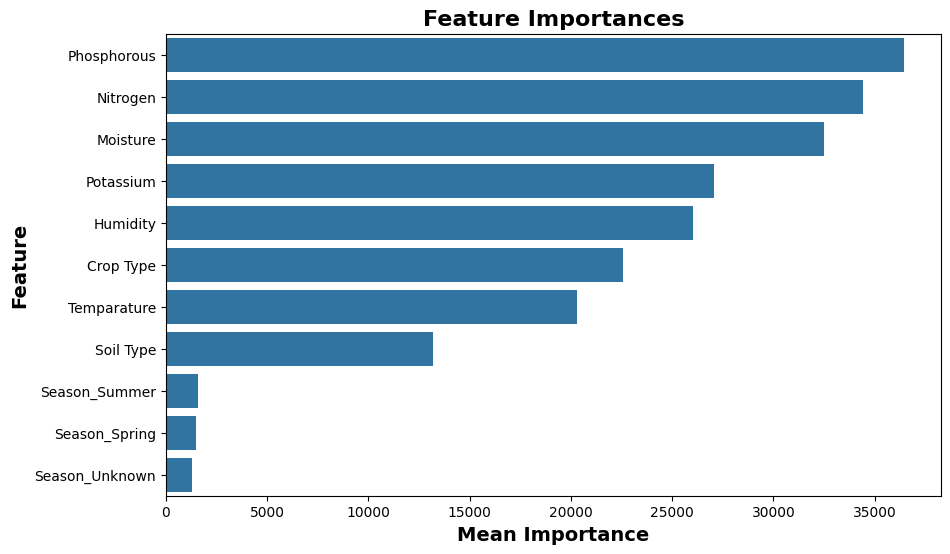

In [21]:
# Model Training and Cross-Validation (XGBoost)
# Define features (X) and target (y)
features = [col for col in train_df.columns if col not in ['id', 'Fertilizer Name']]
X = train_df[features]
y = train_df['Fertilizer Name']

# Label encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# XGBoost model parameters
params = {
    'objective': 'multi:softprob',  # For multi-class classification
    'num_class': len(np.unique(y_encoded)), # Number of classes
    'eval_metric': 'mlogloss',  # Evaluation metric
    'eta': 0.1,  # Learning rate
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# Cross-validation setup
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store predictions and feature importances
oof_preds = np.zeros((len(train_df), len(np.unique(y_encoded))))
test_preds = np.zeros((len(test_df), len(np.unique(y_encoded))))
feature_importances = pd.DataFrame(index=features)

# Cross-validation loop
for fold, (train_index, val_index) in enumerate(skf.split(X, y_encoded)):
    print(f"Fold {fold + 1}/{n_splits}")

    # Split data into train and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(test_df[features])

    # Train the XGBoost model
    model = xgb.train(params, dtrain, num_boost_round=1000,
                      evals=[(dtrain, 'train'), (dval, 'val')],
                      early_stopping_rounds=50, verbose_eval=False)

    # Make predictions on validation and test sets
    oof_preds[val_index] = model.predict(dval)
    test_preds += model.predict(dtest) / n_splits

    # Store feature importances
    feature_importances[f'Fold_{fold + 1}'] = model.get_fscore()

# Calculate overall log loss
overall_logloss = log_loss(y_encoded, oof_preds)
print(f"Overall Log Loss: {overall_logloss}")

# Feature Importance Analysis
feature_importances['Mean'] = feature_importances.mean(axis=1)
feature_importances = feature_importances.sort_values(by='Mean', ascending=False)

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Mean', y=feature_importances.index, data=feature_importances)
plt.title('Feature Importances', fontsize=16, fontweight='bold')
plt.xlabel('Mean Importance', fontsize=14, fontweight='bold')
plt.ylabel('Feature', fontsize=14, fontweight='bold')
plt.show()


# <div style="color:white;display:inline-block;border-radius:5px;background-color:#e6179c ;font-family:Nexa;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;font-size:85%;letter-spacing:0.5px;margin:0;border: 6px groove #ddc0f6;"><b> </b>📊📤Prediction and Submission:</p></div>

This section generates the final predictions and creates the submission file:

- **Predict Top 3 Fertilizers**: For each sample in the test data, the code gets the predicted probabilities for each fertilizer type. It then identifies the top 3 most likely fertilizers based on these probabilities.
- **Create Submission DataFrame**: Creates a DataFrame with two columns: **"id"** (from the test data) and **"Fertilizer Name"** (containing the top 3 predicted fertilizers, separated by spaces).
- **Save Submission File**: Saves the submission DataFrame to a CSV file named **"submission.csv"**, which can be submitted to the competition.

In [22]:
# Prediction and Submission File
# Get top 3 predicted fertilizer names for each test sample
top_3_fertilizers = []
for pred in test_preds:
    top_indices = np.argsort(pred)[-3:][::-1]  # Get indices of top 3 probabilities
    top_fertilizers = label_encoder.inverse_transform(top_indices)  # Map back to fertilizer names
    top_3_fertilizers.append(' '.join(top_fertilizers))

# Create submission DataFrame
submission = pd.DataFrame({'id': test_df['id'], 'Fertilizer Name': top_3_fertilizers})

# Save submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
submission.head()

Submission file created successfully!


,id,Fertilizer Name
0,750000,DAP 10-26-26 28-28
1,750001,17-17-17 20-20 10-26-26
2,750002,20-20 28-28 14-35-14
3,750003,14-35-14 DAP 17-17-17
4,750004,20-20 10-26-26 28-28
